# Introduction




With advancement of Machine learning (ML) as descipline, there are now multiple alternative algorithms that enable computers to learn from data. Such ML algorithms have been used to develop models to solve a range of problems.
However, it is important to note that different machine learning algorithms trained on the same data, and even different configurations of the same algorithm, can yield different results and insights.

A particular concern in the field of machine learning is the explainability of models. In this notebook we describe an approach to compare the explanation results of trained models. The motivation for our work is that different trained models produce different explanation results (interms of which aspects/features of a dataset were particularly useful in producing prediction results).


Explanation results of a particular model can be obtained using SOA algorithms such as SHAP. Comparing explanation results between different models is a difficult task as it requires a domain expertise or background knowledge of the facts. However, an interesting problem is to know how models differ in their explanation results. i.e. how far are two models apart in thier allocation of feature attributions they consider important. A machine learning engineer or data scientist can select most suitable model leveraging these results with performance evaluations that can be obtained using standard perormance metrics such as F score, accuracy, or AUC.


# An example with three bar graphs


XAI tools such as SHAP can produce feature allocations, which show the importance of a feature in the overall prediction decision.

Now before proceeding to actual ML models, lets consider three machine learnign models, ML1, ML2 and ML3 that are trained on a certain dataset with five features. feat1, feat2, feat3, feat4, feat5.
in real world these feature could be customer features, or infrastructure features.
lets say in this example our ML models are classifying bridges that need maintenance with features as follows
(age, location, material, traffic, color)

Now lets create a sample dataframe with feature allocation by each model.




In [3]:
ML1 = [80, 5, 5, 5, 5] # first feature most impact
ML2 = [25, 60, 5, 5, 5] # second feature most imact
ML3 = [5, 5, 5, 5, 80] # last feature most impact

As shown above ML1 assigns higest attribution to first feature (feat1), i.e. bridge age
while ML3 assigns highest attribution to feature 5 (feat5) i.e. bridge color
ML2 on the other hand assigns highest attribution to feat2, followed by feat1, and equal for the rest of features.


what it tells us is that in ML1 age is the most decisive factor to decide the outcome of classifier
while ML3 thinks bridge color is the most important factor.

Now let's visualize these feature attributions with bar plot. 
Before that lets normalize them so that the value will be between zero and one.



In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
# set random seed
np.random.seed(42)
random.seed(42)

# use whitegrid style for plots
sns.set_style("whitegrid")

%matplotlib inline
%config Completer.use_jedi = False

In [5]:
ML1, ML2, ML3 = map(lambda x:x/np.sum(x), [ML1, ML2, ML3])
ML1, ML2, ML3

(array([0.8 , 0.05, 0.05, 0.05, 0.05]),
 array([0.25, 0.6 , 0.05, 0.05, 0.05]),
 array([0.05, 0.05, 0.05, 0.05, 0.8 ]))

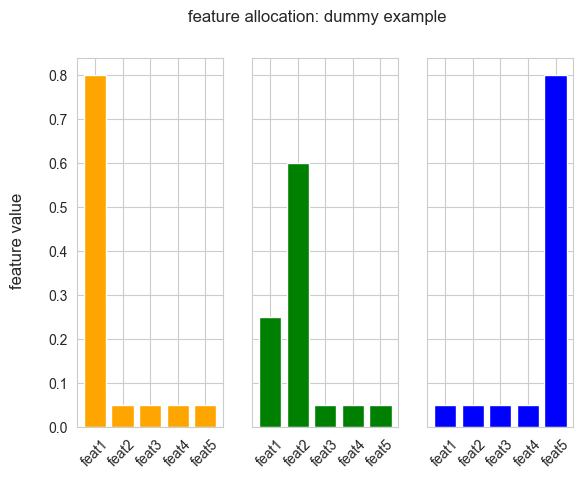

In [6]:
fig, axs = plt.subplots(ncols=3, sharey=True, )
fig.supylabel('feature value')

axs[0].bar(range(5), ML1, color='orange')

axs[1].bar(range(5), ML2, color='g')
axs[2].bar(range(5), ML3, color='b')

for _ in axs:
        _.set_xticks(range(5), ['feat1', 'feat2', 'feat3', 'feat4', 'feat5'], rotation=45)

plt.suptitle('feature allocation: dummy example')
plt.show()

# Computationally computing explanation distances


Since we are considering the feature vectors as distributions of total feature weights, we can study the distance between these feature vectors as distribution distances. 

- there are several distance computation metrics for measuring distribution distances.
- some of the most widely used include wasserstein distance and Kullback-Leibler (KL) divergence.
- In this work we will be using wasserstein distance which is shown to have better performace in various applications such as GANs, image processing, and text processing.

- The wasserstein distance of degree 1, also refered to as the earth mover's distance, measures the ammount of work needed to transform one distribution into another. In Earth mover's distance analogy it is the mass of earth one has to transport to convert one distribution into another.

The fundamental formula is as follows [1].

$ W_p(P, Q) = \left( \sum_{i=1}^n \|X_{(i)} - Y_{(i)}\|^p \right)^{1/p}$

where P and Q represent the distributions with their features vectors X and Y respectively


 [1] https://en.wikipedia.org/wiki/Wasserstein_metric
 


- Once we generate the feature distributions we can use standard distance computation methods
- there are a few distance computation methods to compute distance between distributions, 
- wasserstein distance a.k.a EMD is one of the most common methods.
- the following are good references to the method

    - (https://en.wikipedia.org/wiki/Wasserstein_metric)
    - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wasserstein_distance.html
    - https://pypi.org/project/pyemd/
    - https://www.stat.cmu.edu/~larry/=sml/Opt.pdf

## Computing explanation distances using  first order wasserstein distance.

The following functions provide a simplified implementation of the wasserstein distance of degree 1 i.e. EMD 
Note that these values are not normalized by the total weights (i.e. either by sum(A) or sum(B) as done in the scipy implementation.

We have provided an option to normalize by the sum of total earth at the source

In [8]:
# loop based computation
def simple_wasserstein_distance(A,B, normalize=False):
    """
    wikipeda implementation of simple wasserstein_distance
    """
    n = len(A)
    dist = np.zeros(n)
    for i in range(n-1):
        dist[i+1] = A[i]-B[i]+dist[i]
    return np.sum(abs(dist))


# using pytorch
import torch 
def EMD_tensor(p, q, normalize=False):
    X = torch.as_tensor(p) - torch.as_tensor(q)
    #print(x)
    Y = torch.cumsum(X, dim=0)
    #print(y)
    return Y.abs().sum().numpy()


#vector computation using numpy
def EMD_np(p, q, normalize=False):
    x = p - q
    #print(x)
    y = np.cumsum(x, axis=0)
    #print(y)
    return abs(y).sum()

## Computing distances of the example distributions using the wasserstein distance formulas

In [9]:
# Now lets compute the wasserstein_distance between the three features vectors shown above
simple_wasserstein_distance(ML1, ML2), simple_wasserstein_distance(ML2, ML3), simple_wasserstein_distance(ML1, ML3)

(0.5500000000000004, 2.45, 3.0)

In [10]:
# repeat the same using pytorch, as shown on the wikipedia article
EMD_tensor(ML1, ML2), EMD_tensor(ML2, ML3), EMD_tensor(ML1, ML3)

(array(0.55), array(2.45), array(3.))

In [11]:
# repeat the same using numpy, as shown on the wikipedia article
EMD_np(ML1, ML2), EMD_np(ML2, ML3), EMD_np(ML1, ML3)

(0.5500000000000005, 2.45, 3.0)

As we can see in the above examples the distance between ML1 and ML2 is shorter than between ML1 and ML3. 
We can also see that ML3 is closer to ML2 than ML1

Below we will use a scipy implementation of wasserstein distance

## using scipy implementation of  wasserstein_distance to measure distribution distances
- The scipy.stats library has an implementation of wasserstein_distance which is based on the following paper.

    Ramdas, Garcia, Cuturi "On Wasserstein Two Sample Testing and Related Families of Nonparametric Tests" (2015). :arXiv:1509.02237



In [13]:
# import wasserstein_distance
from scipy.stats import wasserstein_distance

def scipy_wasserstein_distance(p, q):
    """
    given feature vvectors p and q, 
    return their wasserstein_distance as a measure of the distance between them
    """
    return wasserstein_distance(range(len(p)), range(len(q)), u_weights=p, v_weights=q)

In [14]:
scipy_wasserstein_distance(ML1, ML2), scipy_wasserstein_distance(ML2, ML3), scipy_wasserstein_distance(ML1, ML3)

(0.5500000000000002, 2.45, 2.9999999999999996)

As we can see the distance results with scipy provide similar quantification of the distances.
In what follows we will create a heatmap that shows these distance values.

# Visualizing explanation distances.

Below we will create a function that generates a heatmap visualization of the distances we discussed above.

In [15]:
#first lets create dataframes of features
ML_feats = pd.DataFrame(
    {'ML1':ML1, 'ML2':ML2, 'ML3':ML3, 'feats': ['feat1', 'feat2', 'feat3', 'feat4', 'feat5']})
ML_feats

,ML1,ML2,ML3,feats
0,0.80,0.25,0.05,feat1
1,0.05,0.60,0.05,feat2
2,0.05,0.05,0.05,feat3
3,0.05,0.05,0.05,feat4
4,0.05,0.05,0.80,feat5


Text(0, 0.5, 'feature value')

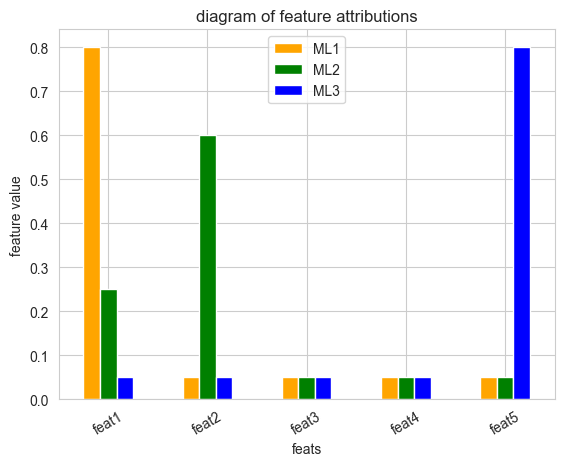

In [16]:
# lets plot them together
sns.set_style('whitegrid')
ML_feats.plot.bar(x='feats', title='diagram of feature attributions', rot=30, color=['orange','g','b'])
plt.ylabel('feature value')

In [17]:
# use heatmap to visualize distance between the feature values as computed via the distance metric
def plot_explanation_distance_heatmap(ML_matrix, title='Heatmap of the explanation distances'):
    ax = sns.heatmap(ML_matrix.astype(float), 
                annot=True, square=True, cmap='Purples_r', linecolor='lightgray', linewidths=.1,
               )
    plt.title(title)
    plt.ylabel('')
    plt.xlabel('')
    plt.show()



# compute the distance matrix

ML_model_names = ML_feats.drop('feats', axis=1).columns
ML_dist_matrix = pd.crosstab(ML_model_names, ML_model_names).applymap(lambda x:None)

for i in ML_model_names:
    for j in ML_model_names:
        ML_dist_matrix.loc[i,j] = scipy_wasserstein_distance(ML_feats[i], ML_feats[j])
ML_dist_matrix

col_0,ML1,ML2,ML3
row_0,,,
ML1,0.0,0.55,3.0
ML2,0.55,0.0,2.45
ML3,3.0,2.45,0.0


In [18]:
ML_feats

,ML1,ML2,ML3,feats
0,0.80,0.25,0.05,feat1
1,0.05,0.60,0.05,feat2
2,0.05,0.05,0.05,feat3
3,0.05,0.05,0.05,feat4
4,0.05,0.05,0.80,feat5


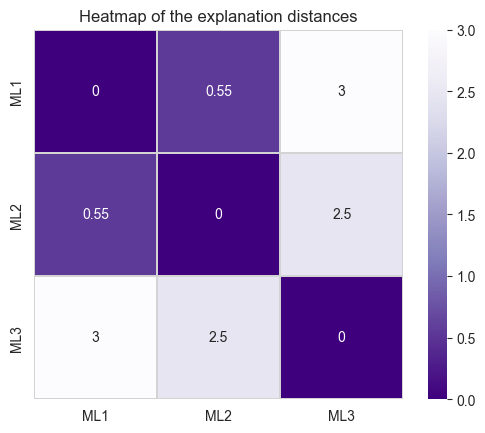

In [19]:
# visualize explanation distances
plot_explanation_distance_heatmap(ML_dist_matrix)

The graph above visually confirms the distance between the feature vectors,
we discussed above which were computed previously.


Next we will use a realistic example on SHAP values using iris dataset to demonstrate the methods.

# A complete example applying it to iris dataset

- so far we have developed a method to compute distances between ML models. 
- In this section we will use a realistic set of ML models on the iris dataset and show the application of it.
- we will demonstrate with six models based on algorithms lightgboost, random forest, decission tree, logistic regression, xgboost.
- We will be using the shap feature attribution method to get the feature values.

In [21]:
# import machine learning libraries and tools

import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# import shap libraries for XAI
import shap

# load the iris dataset and split the data
X_train, X_test, Y_train, Y_test = train_test_split(
    *shap.datasets.iris(), test_size=0.2, random_state=42)

#train models
# init models
model_xgb = xgb.XGBClassifier()
model_lgbm = LGBMClassifier()
model_RF = RandomForestClassifier()
model_DT = DecisionTreeClassifier()
model_LR = LogisticRegression()


# fit models
model_xgb.fit(X_train, Y_train)
model_lgbm.fit(X_train, Y_train)
model_RF.fit(X_train, Y_train)
model_DT.fit(X_train, Y_train)
model_LR.fit(X_train, Y_train)


# make predictions

Y_pred_xgb = model_xgb.predict(X_test)
Y_pred_lgbm = model_lgbm.predict(X_test)
Y_pred_RF = model_RF.predict(X_test)
Y_pred_DT = model_DT.predict(X_test)
Y_pred_LR = model_LR.predict(X_test)

# compute distances

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


## Explanation distances of trained models

In this seection we will do the following

- we will create a function that generates a dataframe of feature allocations/attributions this will help us get feature attribution dataframe of a model from shaplely values
- we will visualize these values using the builtin bar chart
- we will compute the distances using the methods developed above
- the distances will be visualized using a heatmap

In [34]:
def shap_feature_attribution(shap_values):
    """
    returns a sorted list of feature names and their corresponding SHAP values
    tested for 3 class classification problem, needs more testing
    
    """
    
    return (pd.DataFrame(np.mean(abs(shap_values.values),0).mean(1),
                       index = shap_values.feature_names,
                       columns=['mean_abs_shap']
                        )
            .sort_values(by=['mean_abs_shap'],ascending=0)
           )


# visualization of the shap values
def plot_model_explanation(shap_value, X_train):
    # bar plot of feature explanations
    # shap_value = explainer.shap_values(X_train)
    return shap.summary_plot(shap_value, X_train)
    
    

### run the model result for all sample models.
- Note that these models are not tuned for performance, our mere objective here is to show how we can use explanation distances we proposed

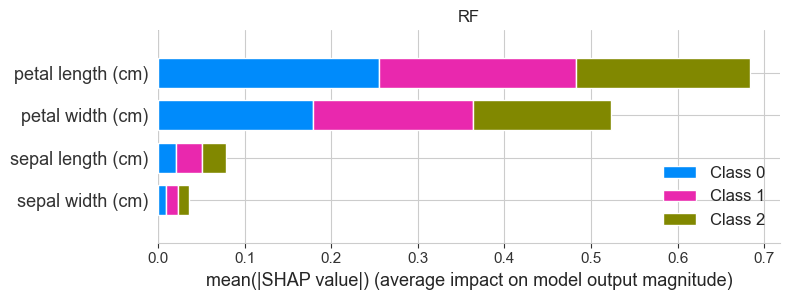

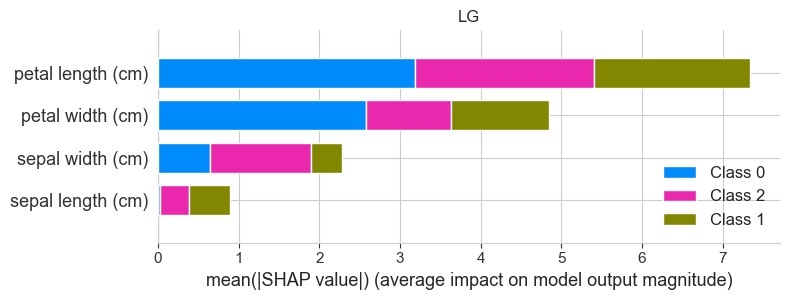

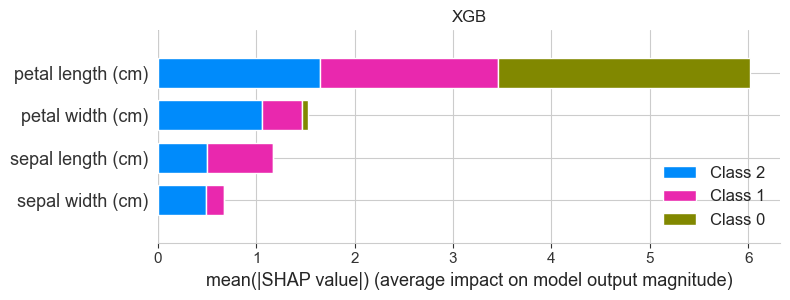

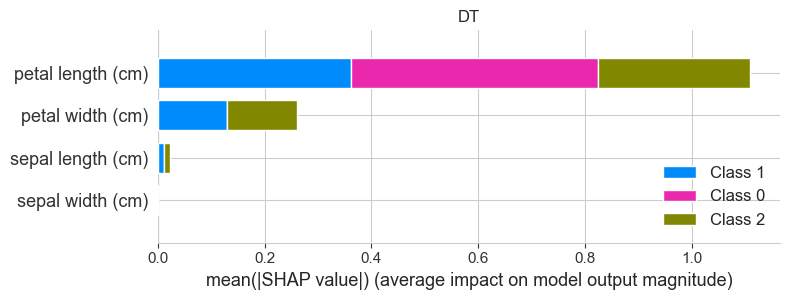

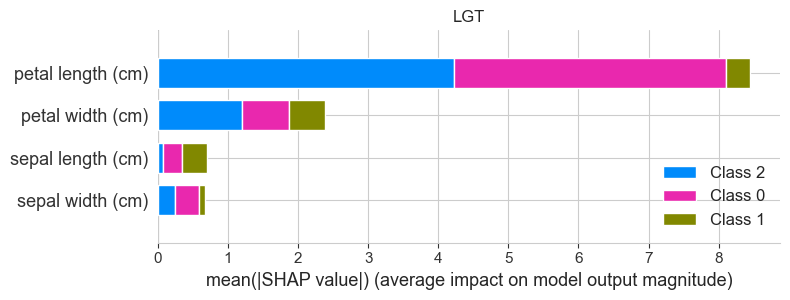

In [35]:
trained_models =  ( ("RF", model_RF), ("LG", model_lgbm), ("XGB", model_xgb), ("DT", model_DT), ("LGT", model_LR))

model_explanations = []


for modeli in trained_models[:]:
    """
    np.alltrue(shaps[0] == shap_values[:,:,0].values)
    
    """
    model_name, amodel = modeli
    explainer = shap.Explainer(amodel, X_train)
    
    if amodel == model_LR:#linear model
        shap_value_obj = explainer.shap_values(X_train) # getting directly from explainer gives feat names
        shap_values = explainer(X_train)
        feat_att = shap_feature_attribution(shap_values)
    else:
        shap_value_obj = explainer.shap_values(X_train, check_additivity=False)
        shap_values = explainer(X_train, check_additivity=False)
        feat_att = shap_feature_attribution(shap_values)
    feat_att.columns = [model_name]
    model_explanations.append(feat_att)
    plt.title(model_name)
    ax = plot_model_explanation(shap_value_obj, X_train)
    

    
    
# now we have all results we need. lets now join them and create the heatmap we developed earlier
model_explanations_df = model_explanations[0].join(model_explanations[1:])

### preparing the matrix and displaying the heatmap


Now we have a complete dataframe of the feature values. we will use the methods we demonstrated in previous sections to generate the distances

For convience of comparison we will normalize results for each model.


In [36]:
# this is our explanation results
model_explanations_df

,RF,LG,XGB,DT,LGT
petal length (cm),0.227986,2.447894,2.007374,0.370009,2.817634
petal width (cm),0.174440,1.616265,0.509806,0.086611,0.796221
sepal length (cm),0.026229,0.297281,0.389528,0.007213,0.233129
sepal width (cm),0.012121,0.760881,0.223446,0.000000,0.225160


In [37]:
# we normalize the results
#model_explanations_df = model_explanations[0].join(model_explanations[1:])
model_explanations_df = model_explanations_df.div(model_explanations_df.max(0), axis='columns')
model_explanations_df

,RF,LG,XGB,DT,LGT
petal length (cm),1.000000,1.000000,1.000000,1.000000,1.000000
petal width (cm),0.765137,0.660268,0.253966,0.234078,0.282585
sepal length (cm),0.115045,0.121443,0.194048,0.019494,0.082739
sepal width (cm),0.053163,0.310831,0.111312,0.000000,0.079911


#### visual inspection of the feature attributions
we show the above dataframe in a bar chart

Text(0, 0.5, 'feature value')

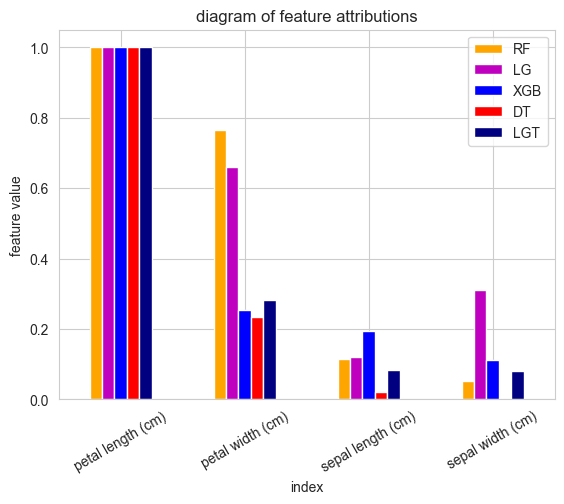

In [38]:
sns.set_style('whitegrid')
model_explanations_df.reset_index().plot.bar(
    x='index', title='diagram of feature attributions', rot=30, color=['orange','m','b', 'r', 'navy'])
plt.ylabel('feature value')

As we can see above the results are different eventough all models assign higest attribution to the first feat.


### Computing the MATRIX
The procedure is the following:

    - we get the names of the models trained
    - we create cross tabulation using these names and fill the results with normalized shap values
    - we apply the distance method we developed in section 3
    - the final value is our distance matrix

In [39]:

trained_model_names = model_explanations_df.columns
model_explanations_matrix = pd.crosstab(trained_model_names, trained_model_names).applymap(lambda x:None)
model_explanations_matrix

for i in trained_model_names:
    for j in trained_model_names:
        model_explanations_matrix.loc[i,j] = scipy_wasserstein_distance(
            model_explanations_df[i], model_explanations_df[j])

model_explanations_matrix

col_0,DT,LG,LGT,RF,XGB
row_0,,,,,
DT,0.0,0.659403,0.258076,0.379433,0.408081
LG,0.659403,0.0,0.401327,0.27997,0.251322
LGT,0.258076,0.401327,0.0,0.228024,0.150005
RF,0.379433,0.27997,0.228024,0.0,0.276776
XGB,0.408081,0.251322,0.150005,0.276776,0.0


### Visualization of the explanation distance using heatmaps

- we use the plot_explanation_distance_heatmap() method we developed aobve to visually show the explnation matrix

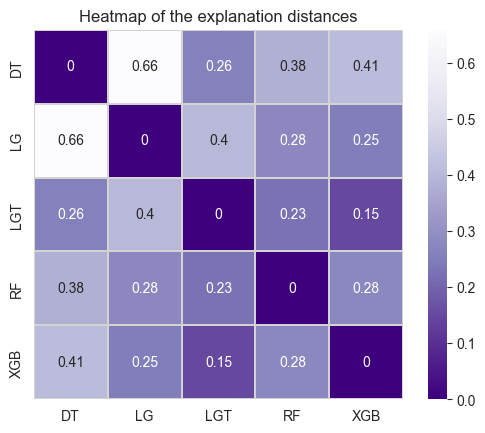

In [40]:
# call plot_explanation_distance_heatmap() with the explanation matrix
plot_explanation_distance_heatmap(model_explanations_matrix)

# Conclusion

In this notebook we showed the need for explanation matrix, demonstrated with simple example, later we used iris dataset to train five different models and computed their shapely values , extracting these feature attributions from the shapely values we computed their explanation distances using wasserstein distance. We finally showed the  how we can generate explanation matrix from computed distances and visually showed the explanation matrix using heatmap.

# todo:

- add alternative distance measures
- test the tool with different data  and models
- compile the functions into a single file that takes a given trained ML model and generates the explanation distance matrix and the shapely values
- we used shap.explain in this approach, which uses optimal explainers for each model. can we find one specific explainer (model agnostic) that we can use for any algorithm, or can we continue with this (do literature review on this)